In [1]:
# Import libraries 
import os
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch 

import pickle 
import matplotlib.pyplot as plt

import numpy as np

import cv2

import  time
import glob

from scipy.io import loadmat

import random
from random import seed, randint

from sklearn.model_selection import train_test_split

import pandas as pd

from imutils.video import FPS

import imutils

from torch.utils.data import DataLoader, Dataset


from threading import Thread
import sys 

from queue import Queue

from imutils.video import FileVideoStream

import numpy as np
import argparse
import imutils
import time

In [2]:

#%% Prepare Data Loader

from data_set_loader import dataPrep


In [3]:
def set_deterministic(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
seed = 42 # any number 
set_deterministic(seed=seed)


In [4]:
with open(files[5], 'rb') as f:
    temp.append(pickle.load(f))

NameError: name 'files' is not defined

In [5]:

#%% Data Directory

files = []
# change the path_dir file
path_dir = '../Data/Pickle_files' # change to folder

# No change here

save_path = path_dir + '_160_160.pkl'




dataPath = os.path.join(path_dir, '*.pkl')
files = glob.glob(dataPath)  # care about the serialization

In [7]:
#%% Dataset Loader (final format)
import pickle
temp, dataSet = [], []

for i in range(2):
    
    with open(files[5], 'rb') as f:
        temp.append(pickle.load(f))
    
    dataSet.append(dataPrep(temp[i]))

In [8]:

#%%

concat_dataset = torch.utils.data.ConcatDataset(dataSet)

data_loader = DataLoader(concat_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

<Figure size 432x288 with 0 Axes>

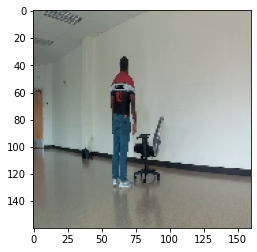

<Figure size 432x288 with 0 Axes>

In [9]:
s1, s2 = next(iter(data_loader))

plt.imshow(np.moveaxis((s1[0][0,:,0,:,:]).cpu().numpy(), 0,2), vmin=0., vmax=1.)
plt.figure()

In [10]:
#%% Network C3D

from C3D_model import C3D
from p3D_net import P3D63, P3D131, P3D199
from torchsummary import  summary


In [11]:
!pip install torchsummary

In [ ]:
#%% Input Model name

ModName = input("Input your model name C3D, P3D199, P3D63, P3D131 \n")

def str_to_class(ModelName):
    return getattr(sys.modules[__name__], ModelName)

ModelName = str_to_class(ModName)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

if ModName == 'C3D':
    net = ModelName()
    net.load_state_dict(torch.load('../../Saved_models/c3d.pickle'))
    net = net.cuda()
    input_shape = (3,16,112,112)
    print(summary(net, input_shape))

elif ModName == 'P3D199':
    net = ModelName(True, 'RGB',num_classes=400)
    # net = net.cuda()
    # input_shape = (3,16,160,160)
    # print(summary(net, input_shape))

elif ModName == 'P3D63' or ModName == 'P3D131':
    net = ModelName(num_classes=400)
    net.to(device)
    input_shape = (3,16,160,160)
    print(summary(net, input_shape))
    
   # more network here!!
    #SLOWFAST

In [13]:
device

device(type='cuda', index=0)

In [ ]:
#%% Removing layer from the mdoel 
import torch.nn as nn
import torch.nn.functional as F


# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
#         self.in_features=2048

#     def forward(self, x):
#         return x
# # net.avgpool = Identity() // OR linear!! 
    
# net.fc = Identity()


num_classes = 10

net.fc = torch.nn.Linear(in_features=2048, out_features= num_classes )
net.cuda()

#%% Optimizer 
#%% Data inference
# netq= nn.Sequential(net, nn.Tanh())

In [ ]:
net.to(device) 
print(summary(net, input_shape))

In [18]:
from data_set_loader import brightness_augment, snp_RGB, test_data

In [19]:
from data_set_loader import brightness_augment, snp_RGB, test_data

#%% 

import torch.nn as nn

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

from losses_PT import TripletLoss1, InfoNceLoss, NT_Xent
L= InfoNceLoss(1)

tan_m =  nn.Tanh()

In [20]:
#%% Training Loop 1 (dataloader)
j = 0
for sample in data_loader:    
    sample = sample.cuda()
    optimizer.zero_grad()   # zero the gradient buffers
    output = tan_m(net(sample[0]))
    loss1 = L(output[0:1], output[1:2], output[2:3])
    loss1.backward()

    optimizer.step()   #%%
    if j%500==0:
        print(loss1.cpu())
        # pdb.set_trace()
    j= j+1
    

tensor(5.3303, grad_fn=<ToCopyBackward0>)
tensor(1.5822, grad_fn=<ToCopyBackward0>)
tensor(1.9382, grad_fn=<ToCopyBackward0>)
tensor(2.0453, grad_fn=<ToCopyBackward0>)
tensor(1.1573, grad_fn=<ToCopyBackward0>)
tensor(0.6592, grad_fn=<ToCopyBackward0>)
tensor(0.6812, grad_fn=<ToCopyBackward0>)
tensor(0.6931, grad_fn=<ToCopyBackward0>)
tensor(0.9894, grad_fn=<ToCopyBackward0>)
tensor(0.4993, grad_fn=<ToCopyBackward0>)
tensor(0.9427, grad_fn=<ToCopyBackward0>)
tensor(0.2391, grad_fn=<ToCopyBackward0>)
tensor(0.3605, grad_fn=<ToCopyBackward0>)
tensor(0.1393, grad_fn=<ToCopyBackward0>)
tensor(0.1440, grad_fn=<ToCopyBackward0>)
tensor(1.9060, grad_fn=<ToCopyBackward0>)
tensor(0.2589, grad_fn=<ToCopyBackward0>)
tensor(2.3617, grad_fn=<ToCopyBackward0>)
tensor(0.1226, grad_fn=<ToCopyBackward0>)
tensor(0.1199, grad_fn=<ToCopyBackward0>)


In [ ]:
#%% Alternate Training Loop (functional)

tdc =  test_data(temp)
j = 0
net.train()
for _ in range(1):
    sample = torch.from_numpy(tdc.get_data_Triplet())
    sample = sample.cuda()
    optimizer.zero_grad()   # zero the gradient buffers
    output = tan_m(net(sample))
    loss1 = L(output[0:1], output[1:2],output[2:3])
    loss1.backward()
    if j%2000==0:
        print(loss1.cpu())
        # pdb.set_trace()
    optimizer.step()   #%%
    j= j+1

In [ ]:
    
#%% SimCLR Alternate training loop from dataloader

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)


L= NT_Xent(batch_size=2, temperature=0.05, world_size=1)
L= L.cuda()

# tdc =  test_data(temp)
j = 0
net.train()


for s1,s2 in data_loader:   
    s1, s2 =  s1[0].cuda(), s2[0].cuda()
    optimizer.zero_grad()   # zero the gradient buffers
    o1, o2 = net(s1),  net(s2)
    loss1 = L(o1, o2)
    loss1.backward()
    optimizer.step() 
    if j%500==0:
        print(loss1.cpu())
        # pdb.set_trace()
    j= j+1

tensor(7.0450, grad_fn=<ToCopyBackward0>)
tensor(1.0684, grad_fn=<ToCopyBackward0>)
tensor(0.6915, grad_fn=<ToCopyBackward0>)
tensor(0.8787, grad_fn=<ToCopyBackward0>)
tensor(1.0734, grad_fn=<ToCopyBackward0>)


In [19]:
#%% SimCLR training loop (functional loop not efficient)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)


L= NT_Xent(batch_size=2, temperature=0.05, world_size=1)
L= L.cuda()

tdc =  test_data(temp) # temp should be one pickle file
j = 0
net.train()


for _ in range(10000):
    s1, s2 = torch.from_numpy(tdc.get_SIMCLR_data()[0]), torch.from_numpy(tdc.get_SIMCLR_data()[1]) 
    s1, s2 =  s1.cuda(), s2.cuda()
    optimizer.zero_grad()   # zero the gradient buffers
    o1, o2 = net(s1),  net(s2)
    loss1 = L(o1, o2)
    loss1.backward()
    optimizer.step() 
    if j%500==0:
        print(loss1.cpu())
        # pdb.set_trace()
    j= j+1

tensor(0.0870, grad_fn=<ToCopyBackward0>)
tensor(0.0876, grad_fn=<ToCopyBackward0>)


KeyboardInterrupt: 

In [26]:
# alternative training to check
L=  InfoNceLoss(.1)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
L = L.cuda()
j = 0
net.train()
for _ in range(80000):
    sample = torch.from_numpy(get_data1())
    sample = sample.cuda()
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(sample)
    loss1 = L(output[0:1], output[1:2],output[2:7])
    loss1.backward()
    if j%500==0:
        print(loss1.cpu())
        # pdb.set_trace()
    optimizer.step()   #%%
    j= j+1

tensor(0.0012, grad_fn=<ToCopyBackward0>)
tensor(0.0039, grad_fn=<ToCopyBackward0>)
tensor(0.0015, grad_fn=<ToCopyBackward0>)
tensor(0.0021, grad_fn=<ToCopyBackward0>)
tensor(0.0034, grad_fn=<ToCopyBackward0>)
tensor(0.0053, grad_fn=<ToCopyBackward0>)
tensor(0.0016, grad_fn=<ToCopyBackward0>)
tensor(0.0023, grad_fn=<ToCopyBackward0>)
tensor(0.0046, grad_fn=<ToCopyBackward0>)
tensor(0.0030, grad_fn=<ToCopyBackward0>)
tensor(0.0016, grad_fn=<ToCopyBackward0>)
tensor(0.0050, grad_fn=<ToCopyBackward0>)
tensor(0.0053, grad_fn=<ToCopyBackward0>)
tensor(0.0053, grad_fn=<ToCopyBackward0>)
tensor(0.0064, grad_fn=<ToCopyBackward0>)
tensor(0.0037, grad_fn=<ToCopyBackward0>)
tensor(0.0062, grad_fn=<ToCopyBackward0>)
tensor(0.0102, grad_fn=<ToCopyBackward0>)
tensor(0.0042, grad_fn=<ToCopyBackward0>)
tensor(0.0034, grad_fn=<ToCopyBackward0>)
tensor(0.0018, grad_fn=<ToCopyBackward0>)
tensor(0.0018, grad_fn=<ToCopyBackward0>)
tensor(0.0041, grad_fn=<ToCopyBackward0>)
tensor(0.0013, grad_fn=<ToCopyBack

In [19]:
optimizer.step()   #%%

net.eval()
with torch.no_grad():
    print(net(sample[0]))

RuntimeError: Expected 5-dimensional input for 5-dimensional weight [64, 3, 1, 7, 7], but got 4-dimensional input of size [3, 16, 160, 160] instead

In [34]:

output

tensor([[ 17.3608, -16.1138,  18.9843, -16.1455,  14.3440,  -2.4596,  -8.6969,
           9.2075,  -9.8223,  -7.0577],
        [ 10.9660, -10.6600,  19.9687,  -9.3135,  11.9770,   7.3316, -18.1618,
          13.8960, -15.1615,  -2.5694],
        [-39.3972,  37.1078, -53.8696,  40.1467, -41.9951,  -1.4261,  34.2604,
         -34.4398,  38.7317,  26.7326]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [21]:

a = np.int16([0, 36*30 , 76*30, 115*30, 156*30,201*30,270*30,316*30, 370*30,435*30])

data_t =[]
data_lab = []
import pdb
net.eval()
for i in range(a.shape[0]-1):
    for _ in range(50):
        sample = torch.from_numpy(get_data_test(randint(a[i], a[i+1])))
        sample = sample.cuda()
        with torch.no_grad():
            output = net(sample)
            # pdb.set_trace()
        data_t.append(output.cpu().numpy())
        data_lab.append([i,i,i])


data_t = np.array(data_t)
data_lab = np.int16(data_lab)
h,w,l = data_t.shape
data_t = data_t.reshape((h*w,l))
data_lab = data_lab.reshape((h*w,1))


In [24]:
data_t[160]

array([ 291.77393 ,  272.9472  ,   90.56079 ,   58.881226,  329.31927 ,
       -228.54753 ,  -76.77939 ,  -32.32723 ,   88.15491 ,  321.24954 ],
      dtype=float32)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1350 samples in 0.001s...
[t-SNE] Computed neighbors for 1350 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1350
[t-SNE] Computed conditional probabilities for sample 1350 / 1350
[t-SNE] Mean sigma: 0.713283
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.012905
[t-SNE] KL divergence after 1000 iterations: 0.314759


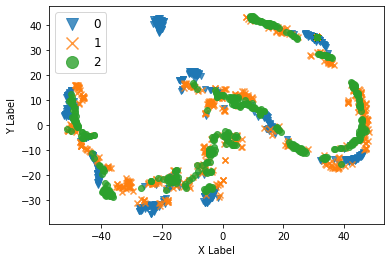

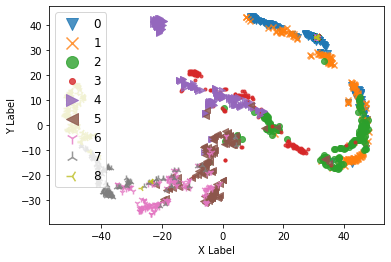

In [22]:
from sklearn.manifold import TSNE

label3 = np.reshape(np.int16([ i for i in range(h*w)])%3, (h*w,1))

def tsne_plot(data = data_t, n_comp = 2, label1 = label3, Lol = None):
    if Lol== None:
        X_embedded = TSNE(n_components=n_comp, verbose=1).fit_transform(data)
    else:
        X_embedded = Lol
            
    
    fig = plt.figure()
    ax = fig.add_subplot()
    if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
    # cdict = {0: 'red', 1: 'blue', 2: 'green'}
    
    markers = ['v', 'x', 'o', '.', '>', '<', '1', '2', '3']
    
    for i, g in enumerate(np.unique(label1)):
        ix = np.where(label1 == g)
        if n_comp==3:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
        else:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = g, alpha = 0.8)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    if n_comp==3:ax.set_zlabel('Z Label')
    if n_comp==3:ax.set_zlabel('Z Label')
    
    
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
    #plt 2
    
    fig = plt.figure()
    ax = fig.add_subplot()
    if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
    # cdict = {0: 'red', 1: 'blue', 2: 'green'}
    markers = ['v', 'x', 'o', '.', '>', '<', '1', '2', '3']
    
    for i, g in enumerate(np.unique(data_lab)):
        ix = np.where(data_lab == g)
        if n_comp==3:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
        else:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = g, alpha = 0.8)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
    
tsne_plot(data_t, 2, label3)

# shillohette coefficient! 

In [68]:
data_lab.shape

(810, 1)

In [68]:
data_t[11]>0

array([False, False])

In [69]:
sample

tensor([[[[[0.5882, 0.5882, 0.5922,  ..., 0.5412, 0.5490, 0.5412],
           [0.5882, 0.5882, 0.5922,  ..., 0.5490, 0.5490, 0.5490],
           [0.5922, 0.5843, 0.5843,  ..., 0.5490, 0.5490, 0.5490],
           ...,
           [0.6902, 0.6902, 0.6824,  ..., 0.6667, 0.6627, 0.6471],
           [0.6902, 0.6863, 0.7216,  ..., 0.6627, 0.6549, 0.6667],
           [0.6980, 0.6824, 0.7059,  ..., 0.6431, 0.6627, 0.6745]],

          [[0.5882, 0.5882, 0.5922,  ..., 0.5412, 0.5490, 0.5490],
           [0.5882, 0.5882, 0.5922,  ..., 0.5451, 0.5490, 0.5490],
           [0.5882, 0.5882, 0.5882,  ..., 0.5490, 0.5490, 0.5490],
           ...,
           [0.6902, 0.6902, 0.6824,  ..., 0.6667, 0.6588, 0.6471],
           [0.6941, 0.6863, 0.7176,  ..., 0.6627, 0.6549, 0.6627],
           [0.6941, 0.6902, 0.7059,  ..., 0.6431, 0.6588, 0.6784]],

          [[0.5882, 0.5804, 0.5922,  ..., 0.5412, 0.5490, 0.5529],
           [0.5882, 0.5882, 0.5922,  ..., 0.5412, 0.5490, 0.5569],
           [0.5922, 0.5882

In [66]:
temp[0]

array([[[[144, 146, 141],
         [144, 146, 141],
         [144, 146, 141],
         ...,
         [138, 138, 135],
         [138, 138, 136],
         [138, 138, 135]],

        [[144, 146, 141],
         [144, 146, 141],
         [143, 145, 140],
         ...,
         [139, 139, 136],
         [139, 139, 136],
         [138, 138, 135]],

        [[144, 146, 141],
         [143, 145, 140],
         [143, 145, 140],
         ...,
         [139, 139, 136],
         [139, 139, 136],
         [139, 139, 136]],

        ...,

        [[167, 166, 155],
         [166, 162, 152],
         [166, 162, 151],
         ...,
         [163, 159, 151],
         [160, 154, 147],
         [159, 153, 146]],

        [[168, 167, 156],
         [168, 164, 154],
         [178, 175, 162],
         ...,
         [161, 156, 148],
         [156, 150, 143],
         [159, 153, 146]],

        [[174, 170, 161],
         [170, 168, 154],
         [177, 174, 161],
         ...,
         [156, 149, 142],
        